# PA005: HIGH VALUE CUSTOMER INDETIFICATION (INSIDERS)

# 0.0 - Imports

 ## 0.1. Imports

In [1]:
import sqlite3
import re
import numpy      as np
import pandas     as pd
import seaborn    as sns

import umap.umap_ as umap

from matplotlib            import pyplot as plt

from sklearn               import cluster       as c
from sklearn               import metrics       as m
from sklearn               import ensemble      as en
from sklearn               import preprocessing as pp
from sklearn               import decomposition as dd
from sklearn               import manifold      as mn
from sklearn               import mixture       as mx

from scipy.cluster import hierarchy as hc
from sqlalchemy import create_engine

from plotly                import express as px

import inflection

from numpy                 import int64

# 1.0 - Data Description

##  1.1. Load dataset

In [2]:
# load data
df_raw = pd.read_csv('C:/Users/DML1WFE/repos/projects/pa005_insiders_clustering/insiders_clustering/data/raw/Ecommerce.csv', encoding='unicode_escape', low_memory=False)

# drop extra column
df_raw = df_raw.drop(['Unnamed: 8'], axis = 1)

##  1.2. Rename Columns

In [3]:
df1 = df_raw.copy()

In [4]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

##  1.3. Data Dimensions

In [5]:
print('Number od rows: {} '.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number od rows: 541909 
Number of columns: 8


## 1.4. Data Types

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

##  1.5. Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

##  1.6. Fillout NA

In [8]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [9]:
# create refrence
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

# merge original with refrence dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra Columns
df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y'], axis = 1)

In [10]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

##  1.7. Chage dtypes

In [11]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'],format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int64)

In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

##  1.8. Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 - Numerical Attributes

In [14]:
# central tendecy - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - desvio padrão, mínimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
#d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() - x.skew())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m1 = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.2 - Categorical Attributes

#### Invoice No

In [15]:
#identificação
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

print('Total number of invoices: {}'.format(len(df_letter_invoices)))
print('Total number of negative quantity: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock code

In [16]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))),'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#  2.0 - Filtering Feature

In [17]:
df2 = df1.copy()

In [18]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [19]:
# ==== Numerical attributes =====
df2 = df2.loc[df2['unit_price']>=0.04, :]

# ==== Categorical attributes =====
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns = 'description', axis = 1)

# map
df2 = df2[~df2['country'].isin(['Unspecified','European Community'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :] 
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

# 3.0 - Feature Engineering

## 3.1. Data

In [20]:
df3 = df2.copy()

## 3.1. Feature Creation

In [21]:
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

In [22]:
df_ref.isna().sum()

customer_id    0
dtype: int64

### 3.1.1 Gross Revenue

In [23]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

C:\Users\dml1wfe\repos\envs\pa005_insiders_clustering\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency - day from last purchase

In [24]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.5 Quantity of products purchased

In [25]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
dtype: int64

###  3.1.8. Frequency Purchase

In [26]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
dtype: int64

###  3.1.9. Number of Returns

In [27]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
qtde_returns      0
dtype: int64

#  4.0 - Exploratory Data Analysis - EDA

In [28]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_products    0
frequency        0
qtde_returns     0
dtype: int64

## 4.3 Estudo do espaço

In [29]:
 # selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[ cols_selected ].drop( columns='customer_id', axis=1 )

In [30]:
df43.head()

,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,5391.21,372.0,297.0,17.000000,40.0
1,3232.59,56.0,171.0,0.028302,35.0
2,6705.38,2.0,232.0,0.040323,50.0
3,948.25,95.0,28.0,0.017921,0.0
4,876.00,333.0,3.0,0.073171,22.0


In [31]:
 mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']  = mm.fit_transform( df43[['recency_days']] )
df43['qtde_products'] = mm.fit_transform( df43[['qtde_products']])
df43['frequency']     = mm.fit_transform( df43[['frequency']])
df43['qtde_returns']  = mm.fit_transform( df43[['qtde_returns']])

X = df43.copy()

In [32]:
X.shape

(5695, 5)

### 4.3.1. PCA

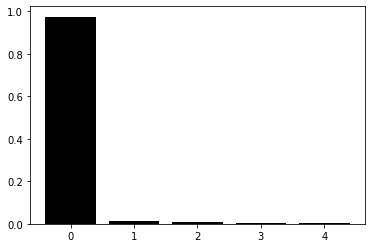

In [33]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot:xlabel='0', ylabel='1'>

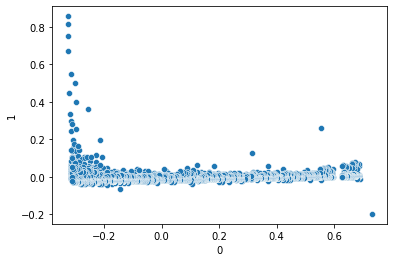

In [34]:
sns.scatterplot( x=0, y=1, data=df_pca )

<AxesSubplot:xlabel='0', ylabel='1'>

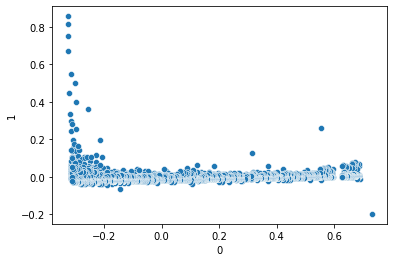

In [35]:
sns.scatterplot( x=0, y=1, data=df_pca )

 ### 4.3.2. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

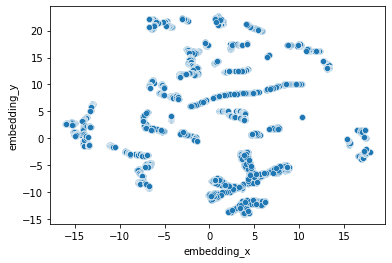

In [36]:
 reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap )

 ### 4.3.3. t-SNE

C:\Users\dml1wfe\repos\envs\pa005_insiders_clustering\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\dml1wfe\repos\envs\pa005_insiders_clustering\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

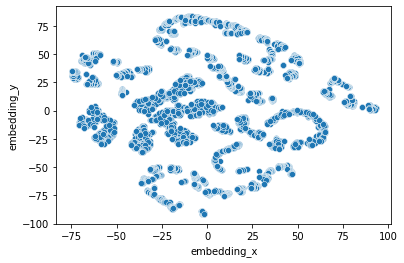

In [37]:
reducer = mn.TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tsne )

### 4.3.4 Tree-Based Embedding

In [38]:
 # training dataset
X = df43.drop( columns=['gross_revenue'], axis=1 )
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 
df_leaf = pd.DataFrame( rf_model.apply( X ) )


C:\Users\dml1wfe\repos\envs\pa005_insiders_clustering\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

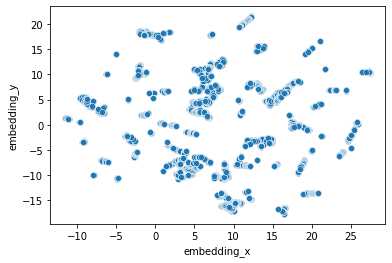

In [39]:
# Reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

 ## 5.0. Data Preparation

In [40]:
# Tree-Based Embedding
df5 = df_tree.copy()
df5.to_csv('../src/data/tree_based_embedding.csv', index = False)


# UMAP Embedding
#df5 = df_umap.copy()

# TSNE Embedding
#df5 = df_tsne.copy()

#  7.0 - Hyperparameter Fine-Tunning

In [41]:
X = df5.copy()

In [42]:
X.head()

,embedding_x,embedding_y
0,6.101183,9.462905
1,7.863738,7.297892
2,6.118375,8.821128
3,-3.336483,-2.578328
4,-7.924327,-9.996942


## 7.1. K-Means

In [43]:
#clusters = [2, 3, 4, 5, 6, 7, 8, 9]
clusters = np.arange( 2, 25, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

In [44]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k, n_init=100, random_state=42 )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

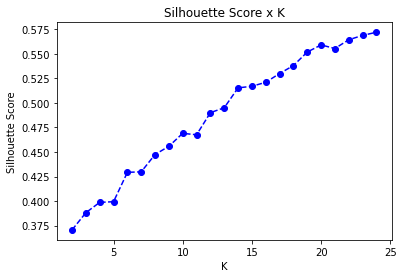

In [45]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2. GMM

In [46]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k, n_init=10, random_state=42 )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

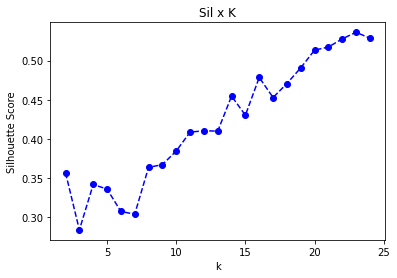

In [47]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

 ### 7.3. Hierarchical Clustering

In [48]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

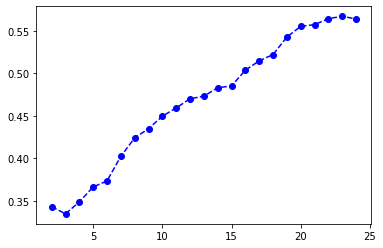

In [49]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

In [50]:
## 7.5. Results - Tree Based Embedding

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.370563,0.388131,0.398649,0.399331,0.429269,0.429790,0.447445,0.455847,0.469049,0.467551,0.490124,0.495109,0.515378,0.517037,0.521061,0.530007,0.538123,0.551899,0.559177,0.555537,0.564450,0.568869,0.572114
GMM,0.356761,0.283936,0.341878,0.335998,0.307511,0.303935,0.363726,0.367176,0.384582,0.408581,0.410421,0.409902,0.454529,0.430248,0.478369,0.452812,0.470576,0.490628,0.513236,0.517184,0.527556,0.536041,0.528404
HC,0.343521,0.334899,0.349118,0.366536,0.373620,0.402449,0.424188,0.434895,0.449551,0.459316,0.470041,0.473088,0.483060,0.485052,0.503703,0.514538,0.521971,0.542487,0.555071,0.557071,0.564033,0.566932,0.563714


In [51]:
## 7.6. Results - UMAP Embedding

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.370563,0.388131,0.398649,0.399331,0.429269,0.429790,0.447445,0.455847,0.469049,0.467551,0.490124,0.495109,0.515378,0.517037,0.521061,0.530007,0.538123,0.551899,0.559177,0.555537,0.564450,0.568869,0.572114
GMM,0.356761,0.283936,0.341878,0.335998,0.307511,0.303935,0.363726,0.367176,0.384582,0.408581,0.410421,0.409902,0.454529,0.430248,0.478369,0.452812,0.470576,0.490628,0.513236,0.517184,0.527556,0.536041,0.528404
HC,0.343521,0.334899,0.349118,0.366536,0.373620,0.402449,0.424188,0.434895,0.449551,0.459316,0.470041,0.473088,0.483060,0.485052,0.503703,0.514538,0.521971,0.542487,0.555071,0.557071,0.564033,0.566932,0.563714


In [52]:
## 7.7. Results - TSNE Embedding

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.370563,0.388131,0.398649,0.399331,0.429269,0.429790,0.447445,0.455847,0.469049,0.467551,0.490124,0.495109,0.515378,0.517037,0.521061,0.530007,0.538123,0.551899,0.559177,0.555537,0.564450,0.568869,0.572114
GMM,0.356761,0.283936,0.341878,0.335998,0.307511,0.303935,0.363726,0.367176,0.384582,0.408581,0.410421,0.409902,0.454529,0.430248,0.478369,0.452812,0.470576,0.490628,0.513236,0.517184,0.527556,0.536041,0.528404
HC,0.343521,0.334899,0.349118,0.366536,0.373620,0.402449,0.424188,0.434895,0.449551,0.459316,0.470041,0.473088,0.483060,0.485052,0.503703,0.514538,0.521971,0.542487,0.555071,0.557071,0.564033,0.566932,0.563714


#  8.0 - Model Training

## 8.1 - Final Model

In [53]:
# model definition
k = 8

## model definition
gmm_model = mx.GaussianMixture( n_components=k, n_init=300, random_state=32 )

# model training
gmm_model.fit( X )

# model predict
labels = gmm_model.predict( X )

## 8.2 - Cluster Validation

In [54]:
  ## WSS ( Within-cluster sum of square)
#print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

SS value: 0.3917904794216156


#  9.0 - Cluster Analysis

In [55]:
df9 = X.copy()
df9['cluster'] = labels

df92.head()

NameError: name 'df92' is not defined

 ## 9.1. Visualization Inspection

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

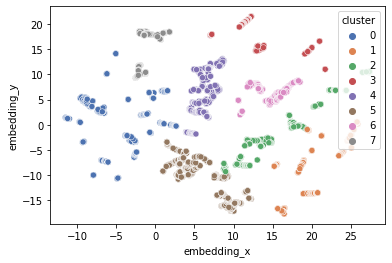

In [ ]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

 ## 9.4. Cluster Profile

In [67]:
df92 = df4[ cols_selected ].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,4
1,13047,3232.59,56.0,171.0,0.028302,35.0,4
2,12583,6705.38,2.0,232.0,0.040323,50.0,4
3,13748,948.25,95.0,28.0,0.017921,0.0,0
4,15100,876.00,333.0,3.0,0.073171,22.0,0


In [68]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['prec_customer'] = 100* (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Average Gross Revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Average Recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# AVg invoice no
df_qtde_products = df92[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qtde_products, how='inner', on='cluster')

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# Returns
df_avg_invoice_no = df92[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')


pd.options.display.float_format = '{:,.2f}'.format
df_cluster.sort_values('gross_revenue', ascending = False)

,cluster,customer_id,prec_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
4,4,1036,18.19,"5,482.87",74.26,295.71,0.34,149.31
6,6,693,12.17,"2,064.18",78.35,131.56,0.36,3.00
0,0,1001,17.58,"1,419.17",104.21,56.15,0.39,7.91
3,3,329,5.78,"1,090.23",92.59,53.36,0.32,12.12
7,7,380,6.67,931.33,114.71,41.13,0.43,3.67
2,2,775,13.61,567.24,116.31,23.81,0.60,6.55
1,1,495,8.69,325.97,201.89,15.88,0.79,2.51
5,5,986,17.31,263.48,168.59,14.39,1.01,1.70


In [69]:
#4 17 Cluster Insiders
#0 16 Cluster More Products
#5 14 Cluster Spend Money
#3 11 Cluster Even More Products
#7 13 Cluster Less days
#2 10 Cluster Less 1K
#6 15 Cluster Stop Returners
#1 12 Cluster More Buy

Cluster 01: (candidato a insider)

    * número de customers : 613 (21% do customers)
    * Faturamento médio: $ 7.494
    * Recência média: 24 dias
    * Media de produtos comprados: 364 produtos
    * Frequencia de compras: 0,09 produtos/dia
   

Cluster 02:

    * número de customers : 6 (0,70% do customers)
    * Recência média: 14 dias
    * Compras média: 53 compras
    * Receita média: $40.543,52 USD

Cluster 03:

    * número de customers : 4.335 (99% do customers)
    * Recência média: 92 dias
    * Compras média: 5 compras
    * Receita média: $1.372,57 USD

# 10.0. Análise Exploratória de Dados

In [70]:
df10 = df92.copy()

In [71]:
df10.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,"5,391.21",372.00,297.00,17.00,40.00,4
1,13047,"3,232.59",56.00,171.00,0.03,35.00,4
2,12583,"6,705.38",2.00,232.00,0.04,50.00,4
3,13748,948.25,95.00,28.00,0.02,0.00,0
4,15100,876.00,333.00,3.00,0.07,22.00,0


# 11.0 - Deploy to Production

In [72]:
df92.dtypes

customer_id        int64
gross_revenue    float64
recency_days     float64
qtde_products    float64
frequency        float64
qtde_returns     float64
cluster            int64
dtype: object

In [73]:
# Change dtypes
df92['recency_days'] = df92['recency_days'].astype(int64)
df92['qtde_products'] = df92['qtde_products'].astype(int64)
df92['qtde_returns'] = df92['qtde_returns'].astype(int64)

In [74]:
# database conection
conn = create_engine('sqlite:///insiders_db.sqlite')

## drop table
#query_drop_insiders = """
#        DROP TABLE insiders
#"""

# create table
query_create_insiders = """
    CREATE TABLE insiders (
        customer_id         INTEGER,    
        gross_revenue       REAL,
        recency_days        INTEGER,
        qtde_products       INTEGER,       
        frequency           REAL,
        qtde_returns        INTEGER,
        cluster             INTEGER

    )
"""

conn.execute (query_create_insiders)

#conn = sqlite3.connect('insiders_db.sqlite')
#conn.execute (query_create_table_insiders)
#conn.commit()
#conn.close()

OperationalError: (sqlite3.OperationalError) table insiders already exists
[SQL: 
    CREATE TABLE insiders (
        customer_id         INTEGER,    
        gross_revenue       REAL,
        recency_days        INTEGER,
        qtde_products       INTEGER,       
        frequency           REAL,
        qtde_returns        INTEGER,
        cluster             INTEGER

    )
]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [75]:
# insert data into
df92.to_sql('insiders', con=conn, if_exists='append', index=False)

In [78]:
## consulting database
#query_colect = """
#    SELECT * from insiders
#
#"""
#df = pd.read_sql_query(query_colect, conn)
#df.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,"5,391.21",372,297,17.00,40,4
1,13047,"3,232.59",56,171,0.03,35,4
2,12583,"6,705.38",2,232,0.04,50,4
3,13748,948.25,95,28,0.02,0,0
4,15100,876.00,333,3,0.07,22,0


,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,"5,391.21",372,297,17.00,40,4
1,13047,"3,232.59",56,171,0.03,35,4
2,12583,"6,705.38",2,232,0.04,50,4
3,13748,948.25,95,28,0.02,0,0
4,15100,876.00,333,3,0.07,22,0
